# Gather required libraries

In [1]:
import scipy
from scipy.integrate import odeint
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Test data

In [2]:
# Given data (time and substrate concentration)

time_data = np.array([0, 1, 3, 10, 30, 60, 100])  # Time points
substrate_data = np.array([1, 0.8, 0.7, 0.5, 0.12, 0.02, 0])  # Substrate concentration over time
product_data1 = np.array([0, 0.20, 0.34, 0.44, 0.52, 0.57, 0.5])  # Concentration of product 1 over time
product_data2 = np.array([0, 0.08, 0.12, 0.17, 0.21, 0.27, 0.3])  # Concentration of product 2 over time
product_data3 = np.array([0, 0.02, 0.05, 0.08, 0.11, 0.13, 0.2])  # Concentration of product 3 over time

# Define functions

In [3]:
# Define exponential depletion function for substrate (initial DNA)
def initial_dna_depletion(t, k_depletion):
    return np.exp(-k_depletion * t)

# Define exponential growth function for product formation 
def product_formation_system_1(t, k_formation1, k_formation2, C1):
    C2 = 1 - C1
    formation_product1 = C1 * (1 - np.exp(-k_formation1 * t))
    formation_product2 = C2 * (1 - np.exp(-k_formation2 * t))
    return formation_product1, formation_product2

#-------------------------------------------------------------------------------------------------------------------------------

# TWO PRODUCTS, NO TRIMMING:

# Define the coupled ODE system for substrate depletion and product formation TWO PRODUCTS, NO TRIMMING
def ode_system_1(t, y, k_depletion, k_formation1, k_formation2, C1):
    S, P1, P2 = y
    C2 = 1 - C1
    dSdt = -k_depletion * S
    dP1dt = k_formation1 * S * C1 * (1 - P2-S)
    dP2dt = k_formation2 * S * C2 * (1 - P1-S)
    return [dSdt, dP1dt, dP2dt]

# Define the fitting function for least squares minimization TWO PRODUCTS, NO TRIMMING
def fitting_function_1(params):
    k_depletion, k_formation1, k_formation2, C1 = params
    # params is a list or array containing the parameters that we want to optimize
    y_predicted = solve_ivp(lambda t, y: ode_system_1(t, y, k_depletion, k_formation1, k_formation2, C1), [time_data[0],
                                                    time_data[-1]], [substrate_data[0], product_data1[0], product_data2[0]],
                                                    t_eval=time_data).y
    
    #The solve_ivp function from scipy.integrate is used to numerically solve the system of ordinary differential equations 
    #(ODEs) defined by the function ode_system.
    
    #We pass the parameters (k_depletion, k_formation1, k_formation2, and C1) along with the initial conditions
    #([substrate_data[0], product_data1[0], product_data2[0]]) to the ode_system.
    
    #The time span for integration is defined by [time_data[0], time_data[-1]], where time_data contains the time points at 
    #which the data is observed.

    #t_eval=time_data ensures that the solver evaluates the solution at the same time points where the data is available.

    residuals_substrate = y_predicted[0] - substrate_data
    residuals_product1 = y_predicted[1] - product_data1
    residuals_product2 = y_predicted[2] - product_data2
    return np.concatenate((residuals_substrate, residuals_product1, residuals_product2))

#-------------------------------------------------------------------------------------------------------------------------------

# TWO PRODUCTS WITH TRIMMING:

# Define the coupled ODE system for substrate depletion and product formation TWO PRODUCTS WITH TRIMMING
def ode_system_2(t, y, k_depletion, k_formation1, k_formation2, k_trimming, C1):
    S, P1, P2 = y
    C2 = 1 - C1
    dSdt = -k_depletion * S
    dP1dt = k_formation1 * S * C1 * (1 - P2) - k_trimming * P1 #k_trimming P1→P2
    dP2dt = k_formation2 * S * C2 * (1 - P1) + k_trimming * P1
    return [dSdt, dP1dt, dP2dt]

# Define the fitting function for least squares minimization TWO PRODUCTS WITH TRIMMING
def fitting_function_2(params):
    k_depletion, k_formation1, k_formation2, k_trimming, C1 = params
    y_predicted = solve_ivp(lambda t, y: ode_system_2(t, y, k_depletion, k_formation1, k_formation2, k_trimming, C1), 
                            [time_data[0],time_data[-1]], [substrate_data[0], product_data1[0], product_data2[0]],
                            t_eval=time_data).y
    residuals_substrate = y_predicted[0] - substrate_data
    residuals_product1 = y_predicted[1] - product_data1
    residuals_product2 = y_predicted[2] - product_data2
    return np.concatenate((residuals_substrate, residuals_product1, residuals_product2))


#-------------------------------------------------------------------------------------------------------------------------------


# THREE PRODUCTS, NO TRIMMING:

# Define exponential growth function for product formation 
def product_formation_system_2(t, k_formation1, k_formation2, k_formation3, C2, C3):
    C1 = 1 - C2 - C3
    formation_product1 = C1 * (1 - np.exp(-k_formation1 * t))
    formation_product2 = C2 * (1 - np.exp(-k_formation2 * t))
    formation_product3 = C3 * (1 - np.exp(-k_formation3 * t))
    return formation_product1, formation_product2, formation_product3


# Define the coupled ODE system for substrate depletion and product formation THREE PRODUCTS, NO TRIMMING
def ode_system_3(t, y, k_depletion, k_formation1, k_formation2, k_formation3, C2, C3):
    S, P1, P2, P3 = y
    C1 = 1 - C2 - C3
    dSdt = -k_depletion * S
    dP1dt = k_formation1 * S * C1 * (1 - P2-P3)
    dP2dt = k_formation2 * S * C2 * (1 - P1-P3)
    dP3dt = k_formation2 * S * C3 * (1 - P1-P2)
    return [dSdt, dP1dt, dP2dt]

# Define the fitting function for least squares minimization THREE PRODUCTS, NO TRIMMING
def fitting_function_3(params):
    k_depletion, k_formation1, k_formation2, k_formation3, C2, C3 = params
    y_predicted = solve_ivp(lambda t, y: ode_system_3(t, y, k_depletion, k_formation1, k_formation2, k_formation3, C2, C3),
                            [time_data[0], time_data[-1]], [substrate_data[0], product_data1[0], product_data2[0], 
                            product_data3[0]], t_eval=time_data).y
    residuals_substrate = y_predicted[0] - substrate_data
    residuals_product1 = y_predicted[1] - product_data1
    residuals_product2 = y_predicted[2] - product_data2
    residuals_product3 = y_predicted[3] - product_data3
    return np.concatenate((residuals_substrate, residuals_product1, residuals_product2, residuals_product3))


# THREE PRODUCTS WITH TRIMMING:

# Define the coupled ODE system for substrate depletion and product formation THREE PRODUCTS WITH TRIMMING
def ode_system_4(t, y, k_depletion, k_formation1, k_formation2, k_formation3, k_trimming1, k_trimming2, k_trimming3, C2, C3):
    S, P1, P2, P3 = y
    C1 = 1 - C2 - C3 
    dSdt = -k_depletion * S
    dP1dt = k_formation1 * S * C1 * (1 - P2-P3) - k_trimming1 * P1 - k_trimming2 * P1
    dP2dt = k_formation2 * S * C2 * (1 - P1-P3) - k_trimming3 * P2 + k_trimming1 * P2
    dP3dt = k_formation2 * S * C3 * (1 - P1-P2) + k_trimming2 * P3 + k_trimming3 * P3
    return [dSdt, dP1dt, dP2dt]

# Define the fitting function for least squares minimization THREE PRODUCTS WITH TRIMMING
def fitting_function_4(params):
    k_depletion, k_formation1, k_formation2, k_formation3, k_trimming1, k_trimming2, k_trimming3, C2, C3  = params
    y_predicted = solve_ivp(lambda t, y: ode_system_4(t, y, k_depletion, k_formation1, k_formation2, k_trimming1, k_trimming2,
                                                      k_trimming3, C2, C3), 
                            [time_data[0],time_data[-1]], [substrate_data[0], product_data1[0], product_data2[0]],
                            t_eval=time_data).y
    residuals_substrate = y_predicted[0] - substrate_data
    residuals_product1 = y_predicted[1] - product_data1
    residuals_product2 = y_predicted[2] - product_data2
    residuals_product3 = y_predicted[3] - product_data3
    return np.concatenate((residuals_substrate, residuals_product1, residuals_product2, residuals_product3))

#-------------------------------------------------------------------------------------------------------------------------------

# Evalutation of the quality of the fit:

def r_squared(y_true, y_pred):
    mean_y = np.mean(y_true)
    ss_total = np.sum((y_true - mean_y)**2)
    ss_residual = np.sum((y_true - y_pred)**2)
    return 1 - (ss_residual / ss_total)

def sum_squared_residuals(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

# TWO PRODUCTS, NO TRIMMING

# Perform fitting 

In [6]:
# Initial guess for parameters
initial_guess1 = [0.1, 0.1, 0.1, 0.7]  # Example initial guess for the parameters

# Fit the fitting function to the data using least squares
result = least_squares(fitting_function_1, initial_guess1)

# Extract the optimal parameters
k_depletion_opt, k_formation1_opt1, k_formation2_opt1, fraction_opt = result.x

# Plot the fitting 

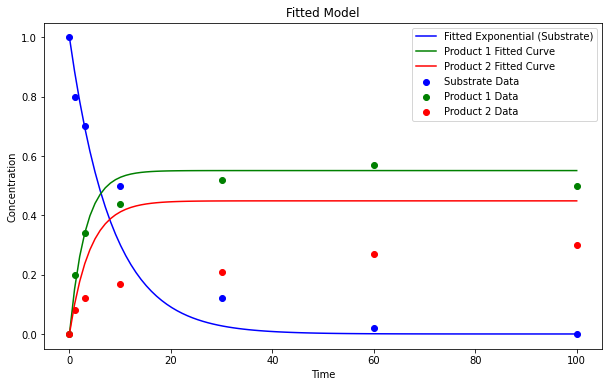

Optimal parameters:
k_depletion: 0.11990617357582271
k_formation1: 0.3181199335875835
k_formation2: 0.2484474396719732
fraction 1: 0.5510658346681139
fraction 2: 0.4489341653318861


In [7]:
### ONE FRACTION PARAMETER

x_values = np.linspace(0, 100, 100)

# Generate points for the fitted curves for substrate and products
substrate_fit = initial_dna_depletion(x_values, k_depletion_opt)
product1_fit1, product2_fit1 = product_formation_system_1(x_values, k_formation1_opt1, k_formation2_opt1, fraction_opt)

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot the original data
plt.scatter(time_data, substrate_data, label='Substrate Data', color='blue')
plt.scatter(time_data, product_data1, label='Product 1 Data', color='green')
plt.scatter(time_data, product_data2, label='Product 2 Data', color='red')

# Plot the fitted curves
plt.plot(x_values, substrate_fit, 'b-', label='Fitted Exponential (Substrate)')
plt.plot(x_values, product1_fit1, 'g-', label='Product 1 Fitted Curve')
plt.plot(x_values, product2_fit1, 'r-', label='Product 2 Fitted Curve')

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Fitted Model')
plt.legend()
plt.show()

# Print optimal parameters
print("Optimal parameters:")
print("k_depletion:", k_depletion_opt)
print("k_formation1:", k_formation1_opt1)
print("k_formation2:", k_formation2_opt1)
print("fraction 1:", fraction_opt)
print("fraction 2:", 1-fraction_opt)

# Determine the quality of the fit 

In [8]:
# Calculate R-squared for substrate and products
r_squared_substrate = r_squared(substrate_data, initial_dna_depletion(time_data, k_depletion_opt))
r_squared_product1 = r_squared(product_data1, product_formation_system_1(time_data, k_formation1_opt1, k_formation2_opt1, 
                                                                        fraction_opt))

# Calculate sum of squared residuals for substrate and products
ssr_substrate = sum_squared_residuals(substrate_data, initial_dna_depletion(time_data, k_depletion_opt))
ssr_product1 = sum_squared_residuals(product_data1, product_formation_system_1(time_data, k_formation1_opt1, k_formation2_opt1, 
                                                                        fraction_opt))

print("R-squared (Substrate):", r_squared_substrate)
print("R-squared (Product 1):", r_squared_product1)

print("Sum of Squared Residuals (Substrate):", ssr_substrate)
print("Sum of Squared Residuals (Product 1):", ssr_product1)


R-squared (Substrate): 0.943291564638603
R-squared (Product 1): 0.7671047536966233
Sum of Squared Residuals (Substrate): 0.05593071967644072
Sum of Squared Residuals (Product 1): 0.05844339852235878


# TWO PRODUCTS WITH TRIMMING

# Perform fitting 

In [9]:
# Initial guess for parameters
initial_guess2 = [0.1, 0.1, 0.1, 0.1, 0.5]  # Example initial guess for the parameters

# Fit the fitting function to the data using least squares
result2 = least_squares(fitting_function_2, initial_guess2)

# Extract the optimal parameters
k_depletion_opt2, k_formation1_opt12, k_formation2_opt12, k_trimming_opt2, fraction_opt2 = result2.x

# Plot the fitting 

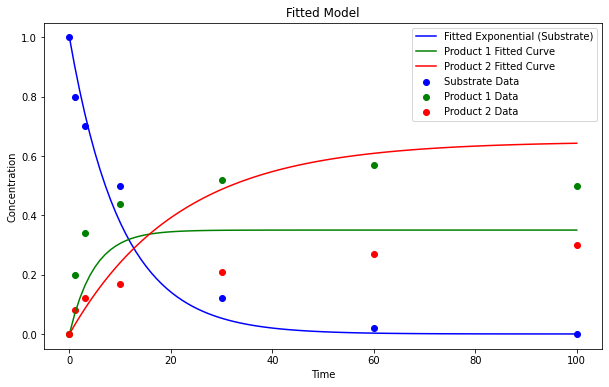

Optimal parameters:
k_depletion: 0.09782991595030145
k_formation1: 0.20552126500771195
k_formation2: 0.046292064056901186
fraction 1: 0.350391953260031
fraction 2: 0.649608046739969


In [10]:
### ONE FRACTION PARAMETER

x_values = np.linspace(0, 100, 100)

# Generate points for the fitted curves for substrate and products
substrate_fit2 = initial_dna_depletion(x_values, k_depletion_opt2)
product1_fit2, product2_fit2 = product_formation_system_1(x_values, k_formation1_opt12, k_formation2_opt12, fraction_opt2)

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot the original data
plt.scatter(time_data, substrate_data, label='Substrate Data', color='blue')
plt.scatter(time_data, product_data1, label='Product 1 Data', color='green')
plt.scatter(time_data, product_data2, label='Product 2 Data', color='red')

# Plot the fitted curves
plt.plot(x_values, substrate_fit2, 'b-', label='Fitted Exponential (Substrate)')
plt.plot(x_values, product1_fit2, 'g-', label='Product 1 Fitted Curve')
plt.plot(x_values, product2_fit2, 'r-', label='Product 2 Fitted Curve')

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Fitted Model')
plt.legend()
plt.show()

# Print optimal parameters
print("Optimal parameters:")
print("k_depletion:", k_depletion_opt2)
print("k_formation1:", k_formation1_opt12)
print("k_formation2:", k_formation2_opt12)
print("fraction 1:", fraction_opt2)
print("fraction 2:", 1-fraction_opt2)

# Determine the quality of the fit 

In [11]:
# Calculate R-squared for substrate and products
r_squared_substrate2 = r_squared(substrate_data, initial_dna_depletion(time_data, k_depletion_opt2))
r_squared_product2 = r_squared(product_data1, product_formation_system_1(time_data, k_formation1_opt12, k_formation2_opt12, 
                                                                        fraction_opt2))

# Calculate sum of squared residuals for substrate and products
ssr_substrate2 = sum_squared_residuals(substrate_data, initial_dna_depletion(time_data, k_depletion_opt2))
ssr_product2 = sum_squared_residuals(product_data1, product_formation_system_1(time_data, k_formation1_opt12, k_formation2_opt12, 
                                                                        fraction_opt2))

print("R-squared (Substrate):", r_squared_substrate2)
print("R-squared (Product 1):", r_squared_product2)

print("Sum of Squared Residuals (Substrate):", ssr_substrate2)
print("Sum of Squared Residuals (Product):", ssr_product2)


R-squared (Substrate): 0.9658864857329963
R-squared (Product 1): -0.29597589316228823
Sum of Squared Residuals (Substrate): 0.033645671785627655
Sum of Squared Residuals (Product): 0.3252158934184108


# THREE PRODUCTS, NO TRIMMING:

# Perform fitting 

In [ ]:
# Initial guess for parameters
initial_guess3 = [0.1, 0.1, 0.1, 0.1, 0.5, 0.5]  # Example initial guess for the parameters

# Fit the fitting function to the data using least squares
result3 = least_squares(fitting_function_3, initial_guess3)

# Extract the optimal parameters
k_depletion_opt3, k_formation1_opt3, k_formation2_opt3, k_formation3_opt3, fraction1_opt3, fraction2_opt3 = result3.x

In [ ]:
# THREE PRODUCTS, NO TRIMMING:

# Define the coupled ODE system for substrate depletion and product formation THREE PRODUCTS, NO TRIMMING
def ode_system_3(t, y, k_depletion, k_formation1, k_formation2, k_formation3, C1, C2, C3):
    S, P1, P2, P3 = y
    dSdt = -k_depletion * S
    dP1dt = k_formation1 * S * C1 * (1 - P2 - P3 - S)
    dP2dt = k_formation2 * S * C2 * (1 - P1 - P3 - S)
    dP3dt = k_formation3 * S * C3 * (1 - P1 - P2 - S)
    return [dSdt, dP1dt, dP2dt, dP3dt]

# Define the fitting function for least squares minimization THREE PRODUCTS, NO TRIMMING
def fitting_function_3(params):
    k_depletion, k_formation1, k_formation2, k_formation3, C1, C2, C3 = params
    # params is a list or array containing the parameters that we want to optimize
    y_predicted = solve_ivp(lambda t, y: ode_system_1(t, y, k_depletion, k_formation1, k_formation2, k_formation3, C1, C2, C3), [time_data[0],
                                                    time_data[-1]], [substrate_data[0], product_data1[0], product_data2[0], product_data3[0]],
                                                    t_eval=time_data).y
    
    #The solve_ivp function from scipy.integrate is used to numerically solve the system of ordinary differential equations 
    #(ODEs) defined by the function ode_system.
    
    #We pass the parameters (k_depletion, k_formation1, k_formation2, and C1) along with the initial conditions
    #([substrate_data[0], product_data1[0], product_data2[0], product_data3[0]]) to the ode_system.
    
    #The time span for integration is defined by [time_data[0], time_data[-1]], where time_data contains the time points at 
    #which the data is observed.

    #t_eval=time_data ensures that the solver evaluates the solution at the same time points where the data is available.

    residuals_substrate = y_predicted[0] - substrate_data
    residuals_product1 = y_predicted[1] - product_data1
    residuals_product2 = y_predicted[2] - product_data2
    residuals_product3 = y_predicted[3] - product_data3
    return np.concatenate((residuals_substrate, residuals_product1, residuals_product2, residuals_product3))
